In [111]:
%config InlineBackend.figure_formats = ['svg']

Over the Summer I [wondered](https://matthodges.com/posts/2024-07-30-austin-hot-or-not/) whether Austin was having a cooler season than normal. Through the magic of public weather data, I was able to discover that the answer was mostly yes!  But I also wrote that post at the end of July, and a lot of 2024 was still left to go. So here I am, sitting at my kitchen counter the day after Christmas, ready to definitively answer the question for the year: Austin, hot or not? Code for how all of this (mostly) works is in the original post, so this update is relatively brief with only the graphs.

In [4]:
import os

import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import pandas as pd
import requests

def get_max_temps(year, limit=366):
    token = os.getenv("NCDC_CDO_TOKEN")
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    params = {
        "datasetid": "GHCND",
        "stationid": "GHCND:USW00013904",
        "startdate": start_date,
        "enddate": end_date,
        "datatypeid": "TMAX",  # max temp
        "units": "standard",  # 🇺🇸
        "limit": limit,  
    }
    headers = {
        "token": token  
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

In [5]:
def to_df(data):
    # Extract date and truncate off the time part
    dates = [item["date"][:10] for item in data["results"]]

    # Grab the max temp value for each date
    max_temps = [item["value"] for item in data["results"]]

    # Create a DataFrame
    df = pd.DataFrame({"date": dates,"max_temp": max_temps})

    # Set the `date` col as a datetime and make it the index
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    
    return df

In [6]:
import time

# Create a dictionary of year:DataFrame
year_dfs = {}
for year in range(2014, 2025):
    year_dfs[year] = to_df(get_max_temps(year))
    # Be a nice internet citizen and wait between requests
    time.sleep(5)

# Adjust pre-2024 dates to match the 2024 index
# This is how we shift the graph to overlap
# If you don't do this, 2024 comes after, not on top of, 2023
for df in year_dfs.values():
    df.index = df.index.map(lambda x: x.replace(year=2024))

First, I wanted to quickly glance at 2023 vs 2024. For a little bit there, this Summer was cooler than last Summer. But then we had a pretty hot week in late August. Year over year, the Summer looks like it was generally cooler than last year, but the Fall has been slightly warmer:

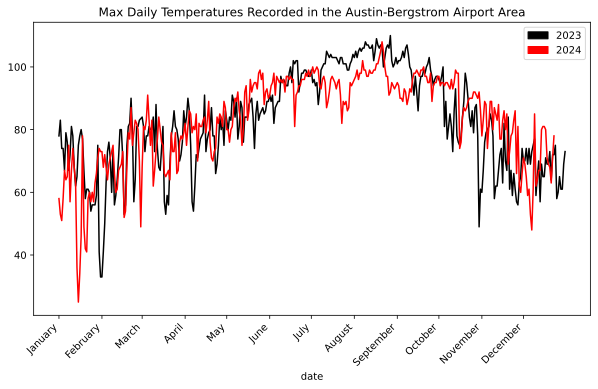

In [114]:
# Adjust 2023 dates to match the 2024 index
# This is how we shift the graph to overlap
# If you don't do this, 2024 comes after, not on top of, 2023
year_dfs[2023].index = year_dfs[2023].index.map(lambda x: x.replace(year=2024))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
year_dfs[2023].plot(ax=ax, color="black", legend="2023")
year_dfs[2024].plot(ax=ax, color="red", legend="2024")

# Sett x-axis to display month labels
ax.set_xticks(
    pd.date_range(
        start=year_dfs[2023].index.min(),
        end=year_dfs[2023].index.max(),
        freq='MS',
    )
)
ax.set_xticklabels(
    pd.date_range(
        start=year_dfs[2023].index.min(),
        end=year_dfs[2023].index.max(),
        freq='MS',
    ).strftime('%B')
)
ax.xaxis.set_minor_locator(plt.NullLocator())

# Formatting
black_patch = mpatches.Patch(color="black", label="2023")
red_patch = mpatches.Patch(color="red", label="2024")
plt.legend(handles=[black_patch, red_patch])
ax.set_title("Max Daily Temperatures Recorded in the Austin-Bergstrom Airport Area")
plt.xticks(rotation=45)

plt.show()

But comparing two years doesn't really reveal a trend (or lack of trend) so here are 2023 and 2024 highlighted over the previous ten years. It's kindof a mess, like if Hulk Hogan couldn't color within the lines. But if you squint you can somewhat pick out some insights.

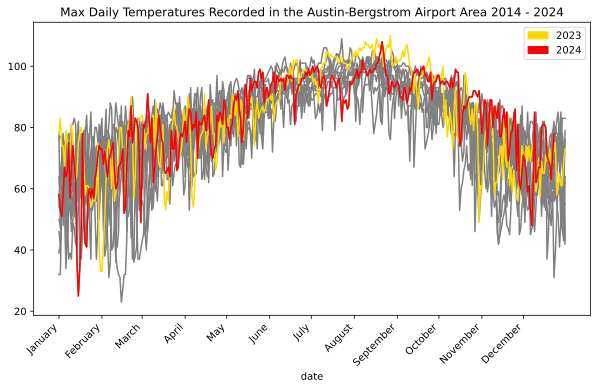

In [113]:
# Adjust pre-2024 dates to match the 2024 index
# This is how we shift the graph to overlap
# If you don't do this, 2024 comes after, not on top of, 2023
for df in year_dfs.values():
    df.index = df.index.map(lambda x: x.replace(year=2024))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
for year, df in year_dfs.items():
    if year == 2023:
         df.plot(ax=ax, label="2023", color="gold")
    else:
        df.plot(ax=ax, color="gray")
year_dfs[2024].plot(ax=ax, label="2024", color="red")

# Sett x-axis to display month labels
ax.set_xticks(
    pd.date_range(
        start=year_dfs[2023].index.min(),
        end=year_dfs[2023].index.max(),
        freq='MS'
    )
)
ax.set_xticklabels(
    pd.date_range(
        start=year_dfs[2023].index.min(),
        end=year_dfs[2023].index.max(),
        freq='MS',
    ).strftime('%B')
)
ax.xaxis.set_minor_locator(plt.NullLocator())

# Formatting
ax.set_title(
    "Max Daily Temperatures Recorded in the Austin-Bergstrom Airport Area 2014 - 2024"
)
plt.xticks(rotation=45)
gold_patch = mpatches.Patch(color="gold", label="2023")
red_patch = mpatches.Patch(color="red", label="2024")
plt.legend(handles=[gold_patch, red_patch])

plt.show()

In [21]:
# Step 1: Concatenate all dataframes along the date index
combined_df = pd.concat(year_dfs.values(), axis=1)

# Step 2: Rename columns to distinguish the max_temp columns from each dataframe
combined_df.columns = [f"max_temp_{year}" for year in year_dfs.keys()]

# Step 3: Calculate the min, max, and average max_temp for each date
combined_df['average_max_temp'] = combined_df.mean(axis=1)
combined_df['min_daily_max_temp'] = combined_df.min(axis=1)
combined_df['max_daily_max_temp'] = combined_df.max(axis=1)

# Step 4: Create a new dataframe with just the average max_temp
averages_df = combined_df[['average_max_temp', 'min_daily_max_temp', 'max_daily_max_temp']]

So here's the final viz I landed on. For most of the Winter and Spring, Austin was oscillating around its 10-year trailing average maximum daily temperature. Then as Summer hit, max temperatures dipped a little bit below average, spiked up in mid August, and then fell again slightly below average until September. From there we’ve been mostly above average!

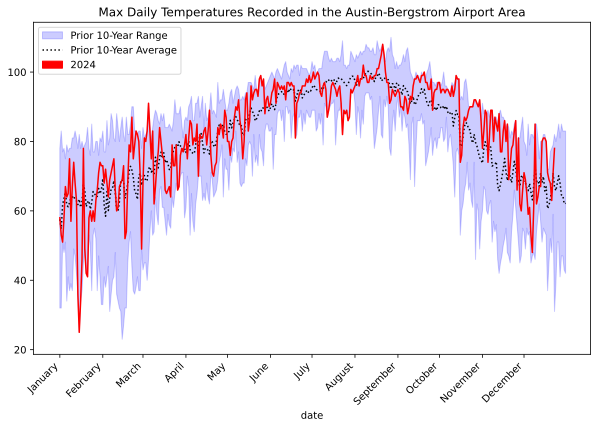

In [112]:
# Adjust 2023 dates to match the 2024 index
# This is how we shift the graph to overlap
# If you don't do this, 2024 comes after, not on top of, 2023
averages_df.index = averages_df.index.map(lambda x: x.replace(year=2024))

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
# band for min and max
ax.fill_between(
    averages_df.index,
    averages_df['min_daily_max_temp'],
    averages_df['max_daily_max_temp'],
    color="blue",
    alpha=0.2,  # Adjust transparency
    label="Prior 10-Year Range"
)
averages_df[['average_max_temp']].plot(ax=ax, color="black", legend="Prior 10-Year Average", linestyle=":")
year_dfs[2024].plot(ax=ax, color="red", legend="2024")

# Sett x-axis to display month labels
date_range = pd.date_range(
    start=averages_df.index.min(),
    end=averages_df.index.max(),
    freq='MS',
)
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%B'))
ax.xaxis.set_minor_locator(plt.NullLocator())
time_delta = averages_df.index.max() - averages_df.index.min()
padding = pd.Timedelta(days=time_delta.days * 0.05)

ax.set_xlim(
    averages_df.index.min() - padding,
    averages_df.index.max() + padding
)
plt.xticks(rotation=45, ha='right')

# Formatting
ax.set_title("Max Daily Temperatures Recorded in the Austin-Bergstrom Airport Area")

from matplotlib.lines import Line2D
blue_patch = mpatches.Patch(color="blue", alpha=0.2, label="Prior 10-Year Range")
black_patch = Line2D([0], [0], color="black", label="Prior 10-Year Average", linestyle=":")
red_patch = mpatches.Patch(color="red", label="2024")
plt.legend(handles=[blue_patch, black_patch, red_patch])


plt.show()

As a final glimpse, we can see how many 2024 days (through December 23, my last day of available data) have crossed above the average max temperature, and how many days stayed below:

In [109]:
above = year_dfs[2024]["max_temp"].gt(averages_df["average_max_temp"]).sum()
below = year_dfs[2024]["max_temp"].lt(averages_df["average_max_temp"]).sum()
print(f"Above Average: {above}")
print(f"Below Average: {below}")


Above Average: 219
Below Average: 137


Thermometers!